# Model Training and Evaluation

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Load encoded dataset
df = pd.read_csv("../Datasets/Encoded_Food_Inspections.csv")
#df = df.sample(n=50000, random_state=42)  # Random sample for reproducibility

# Define target
y = df['IsPass'].astype(int)

# Drop unused columns
X = df.drop(columns=['IsPass', 'Inspection ID', 'Inspection Date', 'Violations', 'Location', 'Address'], errors='ignore')

# Keep only numeric and boolean features
X = X.select_dtypes(include=[np.number, 'bool'])

# Impute missing values as the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

Split and normalize data

In [3]:
# Train/test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, stratify=y, random_state=42)

# Normalize of the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

Fit all of our models: Logistic regression, SVM, Decision Tree, XGBoost, Random Forest, LDA, QDA, and Multi-Layer Perceptron. Depending on the type of model, we'll be using the original (raw) or scaled data to train.

In [4]:
# Logistic Regression (scaled)
log_params = {'C': [0.01, 0.1, 1, 10]}
log_grid = GridSearchCV(LogisticRegression(max_iter=1000), log_params, cv=3, scoring='roc_auc')
log_grid.fit(X_train_scaled, y_train)
log_model = log_grid.best_estimator_
y_pred_log = log_model.predict(X_test_scaled)
y_prob_log = log_model.predict_proba(X_test_scaled)[:, 1]

In [8]:
# Support Vector Machine (scaled)
svm_params = {'C': [0.1, 1, 10], 'kernel': ['rbf']}
svm_grid = GridSearchCV(SVC(probability=True), svm_params, cv=3, scoring='roc_auc')
svm_grid.fit(X_train_scaled, y_train)
svm_model = svm_grid.best_estimator_
y_pred_svm = svm_model.predict(X_test_scaled)
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

In [12]:
# Decision Tree (raw, not scaled)
tree_params = {'max_depth': [3, 5, 7, 10]}
tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_params, cv=3, scoring='roc_auc')
tree_grid.fit(X_train_raw, y_train)
tree_model = tree_grid.best_estimator_
y_pred_tree = tree_model.predict(X_test_raw)
y_prob_tree = tree_model.predict_proba(X_test_raw)[:, 1]

In [7]:
# XGBoost (raw)
xgb_params = {
    "n_estimators":  [300, 600],
    "max_depth":     [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample":     [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "reg_lambda":    [0, 1, 5],
    "reg_alpha":     [0, 0.5, 1],
}
xgb_grid = GridSearchCV(XGBClassifier(tree_method='hist', eval_metric='logloss', random_state=42),
                        xgb_params, cv=3, scoring='roc_auc')
xgb_grid.fit(X_train_raw, y_train)
xgb_model = xgb_grid.best_estimator_
y_pred_xgb = xgb_model.predict(X_test_raw)
y_prob_xgb = xgb_model.predict_proba(X_test_raw)[:, 1]

In [14]:
# Random Forest (raw)
rf_params = {'n_estimators': [100, 200, 300, 500], 'max_depth': [None, 10, 20]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='roc_auc')
rf_grid.fit(X_train_raw, y_train)
rf_model = rf_grid.best_estimator_
y_pred_rf = rf_model.predict(X_test_raw)
y_prob_rf = rf_model.predict_proba(X_test_raw)[:, 1]

Added LDA and QDA too

In [16]:
lda_model = LinearDiscriminantAnalysis().fit(X_train_scaled, y_train)
y_pred_lda  = lda_model.predict(X_test_scaled)
y_prob_lda  = lda_model.predict_proba(X_test_scaled)[:,1]

qda_model = QuadraticDiscriminantAnalysis().fit(X_train_scaled, y_train)
y_pred_qda  = qda_model.predict(X_test_scaled)
y_prob_qda  = qda_model.predict_proba(X_test_scaled)[:,1]

/opt/anaconda3/envs/MyNewEnv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/opt/anaconda3/envs/MyNewEnv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


In [17]:
# Basic PyTorch MLP 

# Prepare tensors & loader
X_tr = torch.from_numpy(X_train_scaled.astype(np.float32))
y_tr = torch.from_numpy(y_train.values.astype(np.float32)).unsqueeze(1)
train_ds = TensorDataset(X_tr, y_tr)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

X_te = torch.from_numpy(X_test_scaled.astype(np.float32))
y_te = torch.from_numpy(y_test.values.astype(np.float32)).unsqueeze(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Manual Grid Search 
import itertools

mlp_param_grid = {
    "hidden":       [32, 64, 128],
    "dropout":      [0.0, 0.2, 0.4],
    "weight_decay": [0, 1e-4, 1e-3],
    "lr":           [1e-3, 3e-3],
}

param_combinations = list(itertools.product(
    mlp_param_grid['hidden'],
    mlp_param_grid['dropout'],
    mlp_param_grid['weight_decay'],
    mlp_param_grid['lr']
))

best_auc = 0
best_params_mlp = None
best_model_mlp = None

for hidden, dropout, weight_decay, lr in param_combinations:
    # Define Model
    class MLP(nn.Module):
        def __init__(self, input_dim):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, hidden),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden, 1)
            )
        def forward(self, x):
            return self.net(x)
    
    model = MLP(X_train_scaled.shape[1]).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train
    model.train()
    for epoch in range(10):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        logits_test = model(X_te.to(device))
        probs_test  = torch.sigmoid(logits_test).cpu().numpy().ravel()

    auc = roc_auc_score(y_test, probs_test)
    if auc > best_auc:
        best_auc = auc
        best_params_mlp = {'hidden': hidden, 'dropout': dropout, 'weight_decay': weight_decay, 'lr': lr}
        best_model_mlp = model
        best_probs_test = probs_test

# Save the best model version
y_prob_mlp = best_probs_test
y_pred_mlp = (y_prob_mlp >= 0.5).astype(int)



We'll define an evaluation function to help us visualize the classification metrics and confusion matrix.

In [9]:
def evaluate_model(name, y_test, y_pred, y_prob):
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    auc = roc_auc_score(y_test, y_prob)
    print(f"AUC-ROC Score: {auc:.3f}")


Time to evaluate all eight models!


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.77      0.72      0.74     19208
           1       0.87      0.89      0.88     38475

    accuracy                           0.83     57683
   macro avg       0.82      0.81      0.81     57683
weighted avg       0.83      0.83      0.83     57683



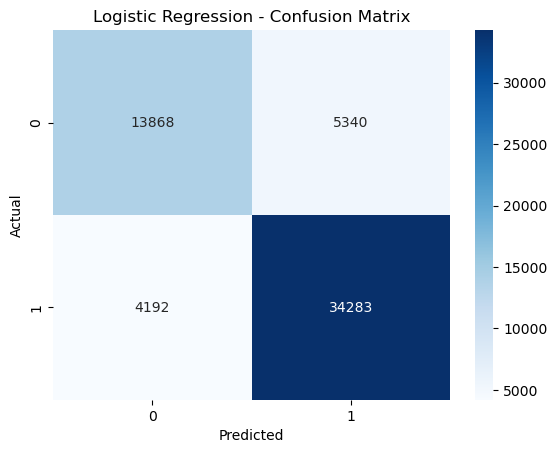

AUC-ROC Score: 0.914

=== Support Vector Machine ===
              precision    recall  f1-score   support

           0       0.81      0.80      0.80     19208
           1       0.90      0.90      0.90     38475

    accuracy                           0.87     57683
   macro avg       0.85      0.85      0.85     57683
weighted avg       0.87      0.87      0.87     57683



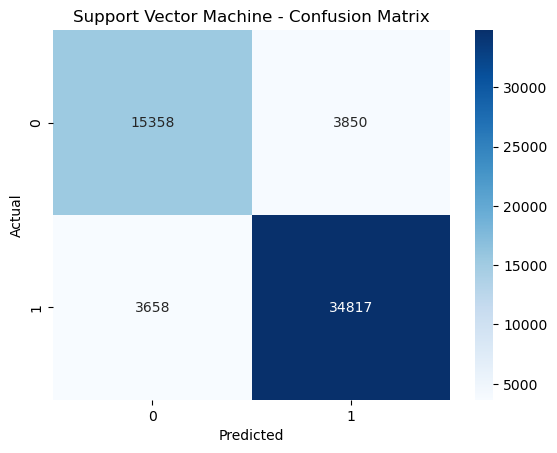

AUC-ROC Score: 0.935

=== Decision Tree ===
              precision    recall  f1-score   support

           0       0.79      0.78      0.79     19208
           1       0.89      0.90      0.89     38475

    accuracy                           0.86     57683
   macro avg       0.84      0.84      0.84     57683
weighted avg       0.86      0.86      0.86     57683



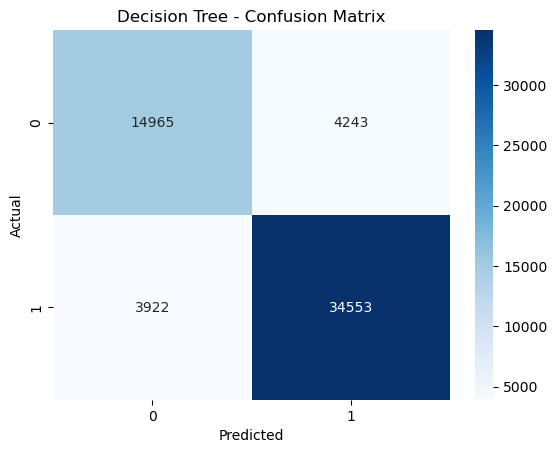

AUC-ROC Score: 0.919

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.83      0.82      0.83     19208
           1       0.91      0.91      0.91     38475

    accuracy                           0.88     57683
   macro avg       0.87      0.87      0.87     57683
weighted avg       0.88      0.88      0.88     57683



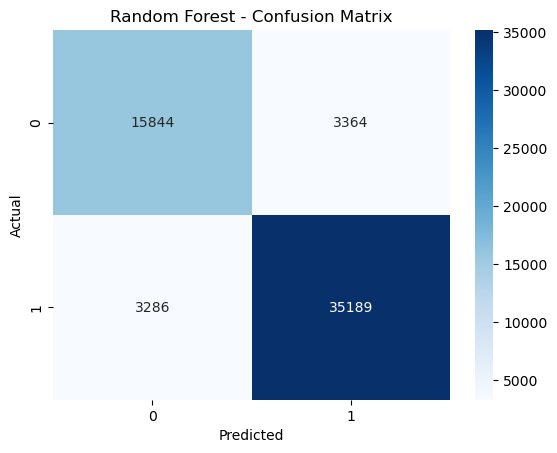

AUC-ROC Score: 0.952

=== XGBoost ===
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     19208
           1       0.92      0.92      0.92     38475

    accuracy                           0.89     57683
   macro avg       0.88      0.88      0.88     57683
weighted avg       0.89      0.89      0.89     57683



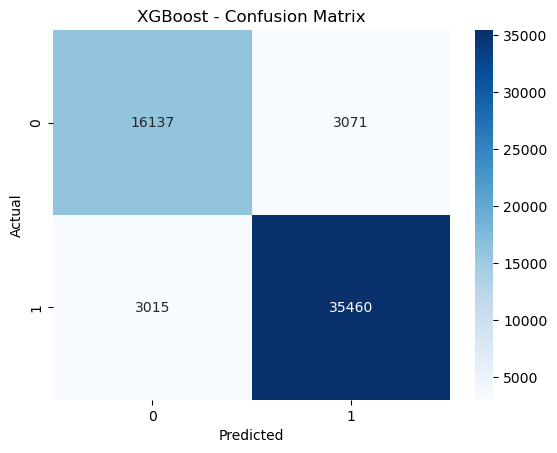

AUC-ROC Score: 0.961

=== LDA ===
              precision    recall  f1-score   support

           0       0.77      0.71      0.74     19208
           1       0.86      0.89      0.88     38475

    accuracy                           0.83     57683
   macro avg       0.82      0.80      0.81     57683
weighted avg       0.83      0.83      0.83     57683



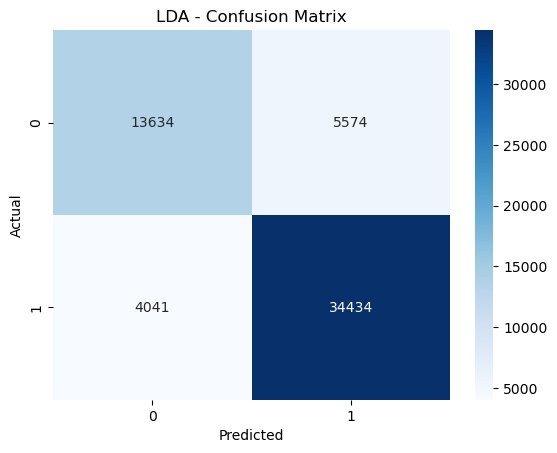

AUC-ROC Score: 0.912

=== QDA ===
              precision    recall  f1-score   support

           0       0.42      0.94      0.58     19208
           1       0.92      0.36      0.51     38475

    accuracy                           0.55     57683
   macro avg       0.67      0.65      0.55     57683
weighted avg       0.75      0.55      0.54     57683



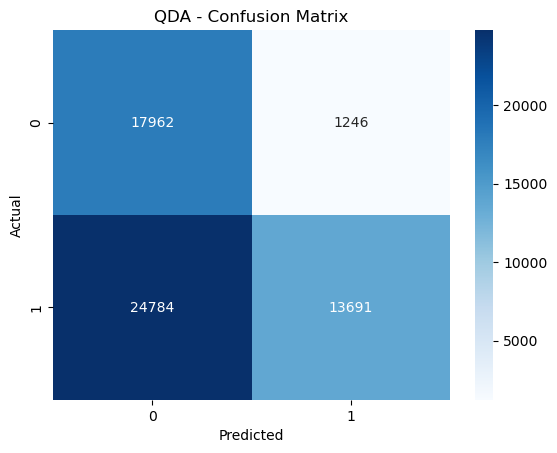

AUC-ROC Score: 0.807

=== MLP ===
              precision    recall  f1-score   support

           0       0.83      0.81      0.82     19208
           1       0.90      0.92      0.91     38475

    accuracy                           0.88     57683
   macro avg       0.87      0.86      0.86     57683
weighted avg       0.88      0.88      0.88     57683



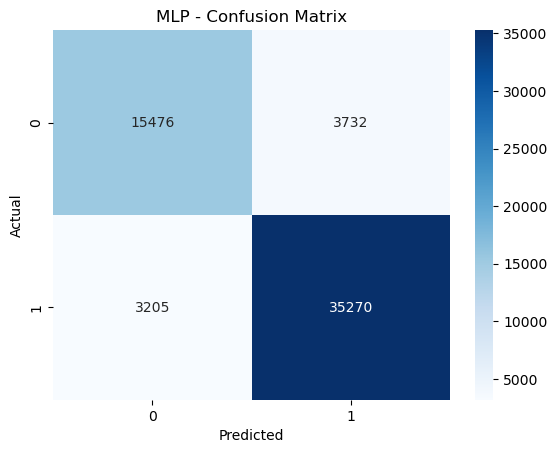

AUC-ROC Score: 0.948


In [18]:
evaluate_model("Logistic Regression", y_test, y_pred_log, y_prob_log)
evaluate_model("Support Vector Machine", y_test, y_pred_svm, y_prob_svm)
evaluate_model("Decision Tree", y_test, y_pred_tree, y_prob_tree)
evaluate_model("Random Forest", y_test, y_pred_rf, y_prob_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb, y_prob_xgb)
evaluate_model("LDA", y_test, y_pred_lda, y_prob_lda)
evaluate_model("QDA", y_test, y_pred_qda, y_prob_qda)
evaluate_model("MLP", y_test, y_pred_mlp, y_prob_mlp)

Create a function to get model metrics so we can later display it in a table.

In [ ]:
def get_metrics(y_true, y_pred, y_prob):
    """Return a dictionary of common classification metrics rounded to 4 decimal points."""
    return {
        'Accuracy': round(accuracy_score(y_true, y_pred), 4),
        'AUC-ROC': round(roc_auc_score(y_true, y_prob), 4),
        'Precision': round(precision_score(y_true, y_pred), 4),
        'Recall': round(recall_score(y_true, y_pred), 4),
        'F1-Score': round(f1_score(y_true, y_pred), 4)
    }


Display summary table

In [27]:
model_names = ['Logistic Regression', 'Support Vector Machine', 'Decision Tree',
               'Random Forest', 'XGBoost', 'LDA', 'QDA', 'MLP']

# List of predictions and probabilities
y_preds = [y_pred_log, y_pred_svm, y_pred_tree, y_pred_rf,
           y_pred_xgb, y_pred_lda, y_pred_qda, y_pred_mlp]

y_probs = [y_prob_log, y_prob_svm, y_prob_tree, y_prob_rf,
           y_prob_xgb, y_prob_lda, y_prob_qda, y_prob_mlp]

# Build metrics summary
summary_list = []
for name, y_pred, y_prob in zip(model_names, y_preds, y_probs):
    metrics = get_metrics(y_test, y_pred, y_prob)
    metrics['Model'] = name
    summary_list.append(metrics)

# Create final summary DataFrame
summary_df = pd.DataFrame(summary_list)
summary_df = summary_df[['Model', 'Accuracy', 'AUC-ROC', 'Precision', 'Recall', 'F1-Score']]
summary_df.sort_values('AUC-ROC', ascending=False, inplace=True)

display(summary_df)


,Model,Accuracy,AUC-ROC,Precision,Recall,F1-Score
4,XGBoost,0.8945,0.9606,0.9203,0.9216,0.9210
3,Random Forest,0.8847,0.9518,0.9127,0.9146,0.9137
7,MLP,0.8797,0.9478,0.9043,0.9167,0.9105
1,Support Vector Machine,0.8698,0.9353,0.9004,0.9049,0.9027
2,Decision Tree,0.8585,0.9192,0.8906,0.8981,0.8943
0,Logistic Regression,0.8348,0.9141,0.8652,0.8910,0.8779
5,LDA,0.8333,0.9121,0.8607,0.8950,0.8775
6,QDA,0.5487,0.8066,0.9166,0.3558,0.5127


In [21]:
print(X.columns.intersection(['IsPass', 'Results', 'Fail_Flag']))
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_raw, y_train)
y_dummy = dummy.predict(X_test_raw)

from sklearn.metrics import accuracy_score
print("Dummy Accuracy:", accuracy_score(y_test, y_dummy))



Index([], dtype='object')
Dummy Accuracy: 0.6670076105611705


Plot Combined ROC Curve

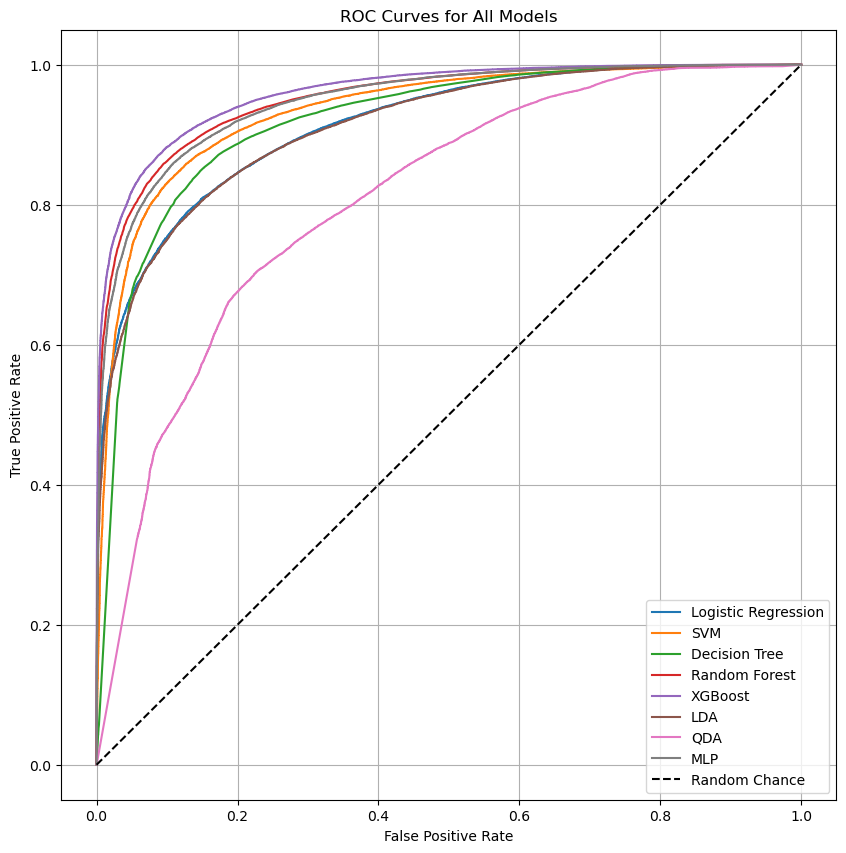

In [22]:
plt.figure(figsize=(10,10))
# ROC curves
for name, probs in [
    ("Logistic Regression", y_prob_log),
    ("SVM",                 y_prob_svm),
    ("Decision Tree",       y_prob_tree),
    ("Random Forest",       y_prob_rf),
    ("XGBoost",             y_prob_xgb),
    ("LDA",                 y_prob_lda),
    ("QDA",                 y_prob_qda),
    ("MLP",                 y_prob_mlp),
]:
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=name)

# Plot
plt.plot([0,1],[0,1],'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend()
plt.grid(True)
plt.show()
